In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('bank-full.csv', sep=';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
cols = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]


In [5]:
df = df[cols]
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df['y'] = df.y.map({'yes': 1, 'no': 0})

## Split into train, test, val sets

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [8]:
df_full_train, df_val = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(len(df_train), len(df_val), len(df_test))

27126 9043 9042


In [9]:
df_train = df_train.reset_index(drop='True')
df_val = df_val.reset_index(drop='True')
df_test = df_test.reset_index(drop='True')

target = 'y'
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

del df_train[target]
del df_val[target]
del df_test[target]

In [10]:
numerical = [col for col in df_train.columns if df[col].dtype != 'object']
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [11]:
categorical = [col for col in df_train.columns if df[col].dtype == 'object']
categorical

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

# Q.1

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [13]:
roc_auc_scores = []
for c in numerical:
  score = roc_auc_score(y_train, df_train[c])
  if score < 0.5:
    score = roc_auc_score(y_train, -df_train[c])
  roc_auc_scores.append(({'variable': c, 'score': score}))
df_scores = pd.DataFrame(roc_auc_scores)
df_scores.sort_values(by='score', ascending=False)


,variable,score
3,duration,0.814700
6,previous,0.598565
5,pdays,0.590128
1,balance,0.588831
4,campaign,0.571454
2,day,0.525958
0,age,0.512186


## Ans.  duration

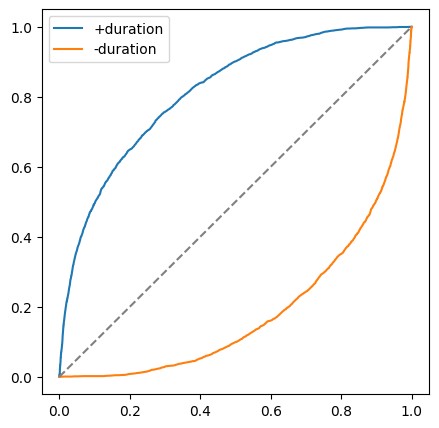

In [14]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.duration)
plt.plot(fpr, tpr, label='+duration')

fpr, tpr, _ = roc_curve(y_train, -df_train.duration)
plt.plot(fpr, tpr, label='-duration')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()


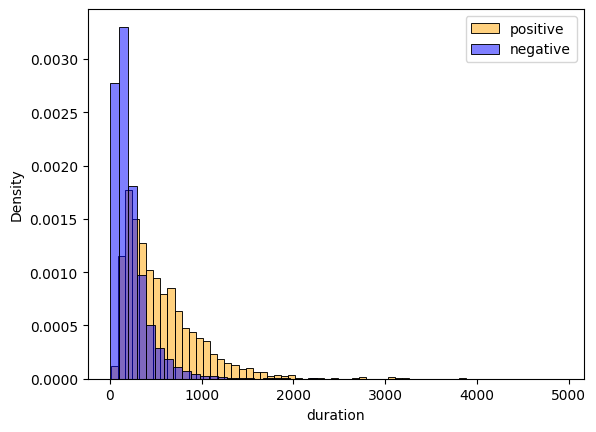

In [15]:
sns.histplot(df_train.duration[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.duration[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()


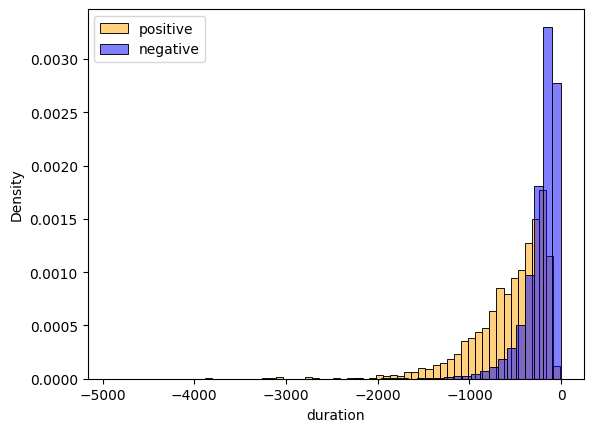

In [16]:
sns.histplot(-df_train.duration[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(-df_train.duration[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()



# Q.2.

In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
dv = DictVectorizer(sparse=False)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [18]:
df_train.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
0,56,entrepreneur,married,tertiary,40,no,cellular,11,jul,123,2,-1,0,unknown
1,33,technician,married,secondary,4790,yes,cellular,20,apr,137,1,272,2,failure
2,32,technician,single,tertiary,392,yes,cellular,21,nov,148,2,-1,0,unknown
3,40,admin.,divorced,secondary,2129,no,cellular,30,apr,452,1,-1,0,unknown
4,54,unemployed,married,tertiary,1180,no,cellular,19,nov,394,2,-1,0,unknown


In [19]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [20]:
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
val_score = roc_auc_score(y_val, y_pred)
round(val_score, 3)

0.907

In [21]:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.6550212983980029

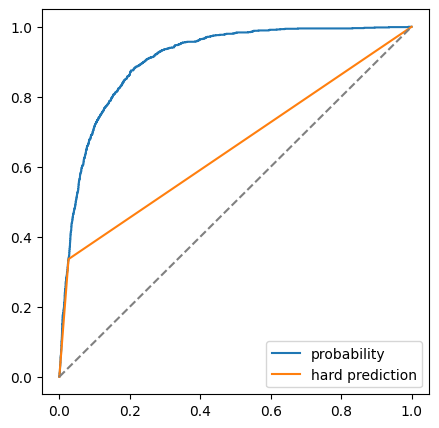

In [22]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

In [23]:
X_test = dv.transform(test_dict)
test_pred = model.predict_proba(X_test)[:, 1]
test_score = roc_auc_score(y_test, test_pred)
round(test_score, 3)

0.9

# Ans. .907

# Q.3

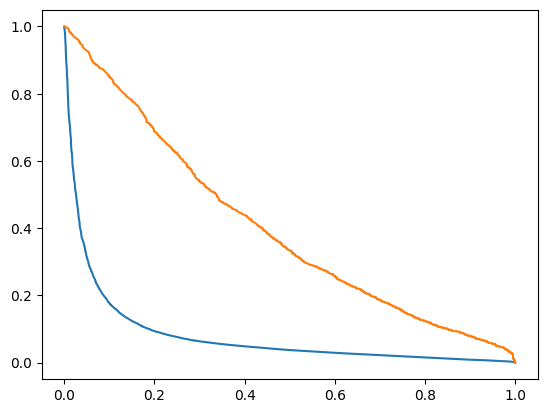

In [24]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.plot(fpr, thresholds)
plt.plot(tpr, thresholds)
plt.show()

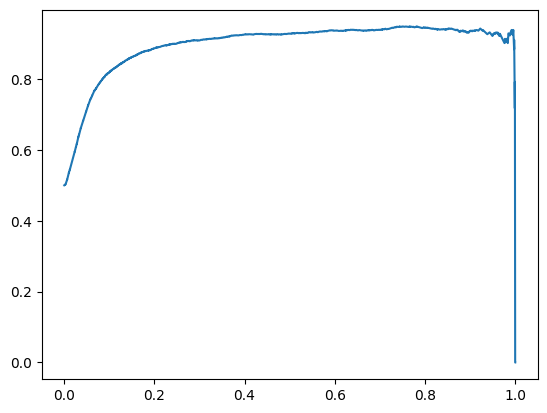

In [25]:
precision = tpr / (tpr + fpr)
plt.plot(thresholds, precision)
plt.show()

In [26]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [27]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [28]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)


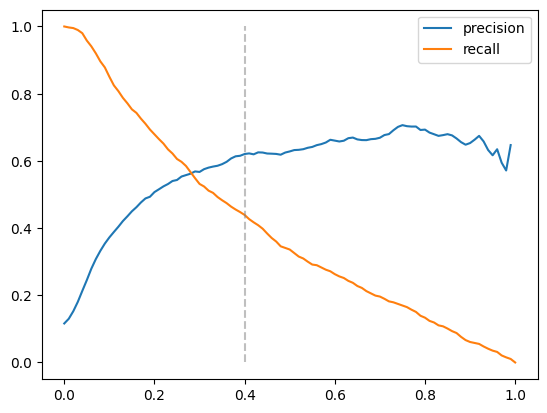

In [29]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

plt.vlines(0.4, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

## Ans. .265

# Q.4

In [30]:
F1 = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

In [31]:
F1.idxmax()

22

In [32]:
F1.iloc[22]

0.580891719745223

In [33]:
df_scores['F1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

In [34]:
df_scores['F1'].max()

0.580891719745223

In [35]:
# prompt: write the code to determine df_scores.threshold at which df_scores['F1'].max() occurs

df_scores.loc[df_scores['F1'].idxmax(), 'threshold']


0.22

In [36]:
df_scores.iloc[18:25]

,threshold,tp,fp,fn,tn,precision,recall,F1
18,0.18,746,782,304,7211,0.488220,0.710476,0.578743
19,0.19,728,748,322,7245,0.493225,0.693333,0.576405
20,0.20,713,693,337,7300,0.507112,0.679048,0.580619
21,0.21,698,656,352,7337,0.515510,0.664762,0.580699
22,0.22,684,621,366,7372,0.524138,0.651429,0.580892
23,0.23,666,588,384,7405,0.531100,0.634286,0.578125
24,0.24,653,556,397,7437,0.540116,0.621905,0.578132


# Ans. .22

# Q.5

In [37]:
def train(df_train, y_train, C=1.0):
  dicts = df_train[categorical + numerical].to_dict(orient='records')

  dv = DictVectorizer(sparse=False)
  X_train = dv.fit_transform(dicts)

  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
  model.fit(X_train, y_train)

  return dv, model

In [38]:
def predict(df, dv, model):
  dicts = df[categorical + numerical].to_dict(orient='records')

  X = dv.transform(dicts)
  y_pred = model.predict_proba(X)[:, 1]

  return y_pred

In [39]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [40]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = df_train.y.values
  y_val = df_val.y.values

  dv, model = train(df_train, y_train)
  y_pred = predict(df_val, dv, model)

  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


## Ans.  .006

In [41]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = df_train.y.values
  y_val = df_val.y.values

  dv, model = train(df_train, y_train)
  y_pred = predict(df_val, dv, model)

  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


# Q.6

In [42]:
Cs = [0.000001, 0.001, 1]

In [46]:
scores = []
stds = []
for C in Cs:

  for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
  stds.append({'C': C, 'mean': np.mean(scores), 'std': np.std(scores)})

  df_scores = pd.DataFrame(stds)
print(df_scores)

          C      mean       std
0  0.000001  0.701445  0.009444
1  0.001000  0.781144  0.080140
2  1.000000  0.822718  0.088028


# Ans.  1.0 with a mean score of .823